In [1]:
%load_ext autoreload
%autoreload 2

import os
import re
import random
import warnings
from collections import defaultdict
from itertools import product

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
from matplotlib.ticker import MaxNLocator

import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import gaussian_kde, kruskal

from joblib import load

from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

import shap
import umap.umap_ as umap
import wfdb

from PTBXLModel import PTBXLModel
from scikit_posthocs import posthoc_dunn

# Suppress specific warnings
warnings.filterwarnings("ignore")

# Set display format for pandas
pd.options.display.float_format = "{:.3f}".format

# Set plot style and parameters
plt.style.use('tableau-colorblind10')
plt.rcParams.update({
    'axes.titlesize': 22,
    'axes.labelsize': 15,
    'axes.labelpad': 14,
    'xtick.labelsize': 12,
    'xtick.major.pad': 5,
    'ytick.labelsize': 12,
    'ytick.major.pad': 5,
    'legend.fontsize': 14,
    'figure.figsize': (10, 8)
})

# Define color palette
palette = {
    "CD": "#1583d1",
    "HYP": "#de5f04",
    "MI": "#d60b0b",
    "NORM": "#2e9c19",
    "STTC": "#720ec4",
}

# Constants
ID = "ecg_id"
GROUP = "patient_id"
FOLD = "strat_fold"
RANDOM_STATE = 2024 
N_JOBS = 10

# Fixing deprecated numpy int
np.int = int

d:\MSc - AI\Internship\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Data loading

In [2]:
X = pd.read_csv("../data/3dfmmecg_features.csv").sort_values(by="ecg_id")
strat_fold = X[FOLD]
X.head()

,ecg_id,strat_fold,age,sex,height,weight,A_P_I_mean,A_P_I_std,A_Q_I_mean,A_Q_I_std,...,β_T_aVR_circmean,β_T_aVR_circstd,β_T_aVL_circmean,β_T_aVL_circstd,β_T_aVF_circmean,β_T_aVF_circstd,RR_mean,RR_std,HR_mean,HR_std
0,1,3,56.000,1,NaN,63.000,63.644,17.746,140.204,16.215,...,0.093,0.090,3.442,0.175,3.127,0.098,937.000,15.964,64.050,1.088
1,2,2,19.000,0,NaN,70.000,30.480,19.242,117.139,18.539,...,0.396,0.195,3.619,0.158,3.431,0.521,1271.333,82.507,47.362,3.104
2,3,5,37.000,1,NaN,69.000,52.809,6.817,93.192,17.091,...,NaN,NaN,NaN,NaN,NaN,NaN,940.222,20.011,63.840,1.346
3,4,3,24.000,0,NaN,82.000,61.792,10.819,223.413,18.801,...,0.075,0.145,3.349,1.045,3.166,0.330,806.000,38.812,74.596,3.525
4,5,4,19.000,1,NaN,70.000,29.572,7.502,77.725,13.966,...,6.242,0.110,4.931,0.871,3.001,0.145,905.200,51.538,66.478,3.802


In [3]:
y = pd.read_csv("../data/y_superdiag.csv").sort_values(by="ecg_id")
y = y.drop(columns=["ecg_id"])
y = (y > 0).astype(int)
y['label'] = y.idxmax(axis=1)
y.head()

,NORM,MI,STTC,HYP,CD,label
0,1,0,0,0,0,NORM
1,1,0,0,0,0,NORM
2,1,0,0,0,0,NORM
3,1,0,0,0,0,NORM
4,1,0,0,0,0,NORM


In [4]:
train_idx = X.loc[X[FOLD] <= 8, "ecg_id"].values
val_idx = X.loc[X[FOLD] == 9, "ecg_id"].values
test_idx = X.loc[X[FOLD] == 10, "ecg_id"].values


X_train = X.loc[X["ecg_id"].isin(train_idx),:]
X_train = X_train.reset_index(drop=True)
X_train = X_train.loc[:, ~X.columns.isin([ID, GROUP, FOLD])]
print(X_train.shape)

X_val = X.loc[X["ecg_id"].isin(val_idx),:]
X_val = X_val.reset_index(drop=True)
X_val = X_val.loc[:, ~X.columns.isin([ID, GROUP, FOLD])]
print(X_val.shape)

X_test = X.loc[X["ecg_id"].isin(test_idx),:]
X_test = X_test.reset_index(drop=True)
X_test = X_test.loc[:, ~X.columns.isin([ID, GROUP, FOLD])]
print(X_test.shape)


X = X.loc[:, ~X.columns.isin([ID, GROUP, FOLD])]
X_test.head()

(17418, 316)
(2183, 316)
(2198, 316)


,age,sex,height,weight,A_P_I_mean,A_P_I_std,A_Q_I_mean,A_Q_I_std,A_R_I_mean,A_R_I_std,...,β_T_aVR_circmean,β_T_aVR_circstd,β_T_aVL_circmean,β_T_aVL_circstd,β_T_aVF_circmean,β_T_aVF_circstd,RR_mean,RR_std,HR_mean,HR_std
0,55.000,0,NaN,70.000,43.334,21.739,121.918,11.502,183.108,17.767,...,NaN,NaN,NaN,NaN,NaN,NaN,986.250,37.178,60.914,2.355
1,40.000,0,NaN,72.000,25.952,9.654,62.336,46.305,112.232,22.330,...,0.264,0.082,5.342,0.197,3.192,0.075,823.400,17.690,72.898,1.547
2,60.000,0,NaN,85.000,59.974,6.148,79.112,21.796,591.165,44.631,...,NaN,NaN,NaN,NaN,NaN,NaN,935.778,11.766,64.127,0.807
3,26.000,0,NaN,93.000,68.863,13.030,163.288,12.444,372.918,74.196,...,NaN,NaN,NaN,NaN,NaN,NaN,921.556,31.189,65.175,2.254
4,54.000,0,NaN,67.000,25.256,7.263,102.538,11.585,170.547,32.473,...,0.112,0.119,3.607,0.206,2.997,0.115,847.200,13.734,70.838,1.143


## Feature number

In [5]:
feature_num = []

method = "3dfmmecg"
X_aux = pd.read_csv(f"../data/{method}_features.csv").sort_values(by="ecg_id")
X_aux = X_aux.loc[:, ~X_aux.columns.isin([ID, GROUP, FOLD])]
feature_num.append(X_aux.shape[1])

method = "unig"
X_aux = pd.read_csv(f"../data/{method}_features.csv").sort_values(by="ecg_id")
X_aux = X_aux.loc[:, ~X_aux.columns.isin([ID, GROUP, FOLD])]
feature_num.append(X_aux.shape[1])

method = "ecgdeli"
X_aux = pd.read_csv(f"../data/{method}_features.csv").sort_values(by="ecg_id")
X_aux = X_aux.loc[:, ~X_aux.columns.isin([ID, GROUP, FOLD])]
feature_num.append(X_aux.shape[1])

method = "12sl"
X_aux = pd.read_csv(f"../data/{method}_features.csv").sort_values(by="ecg_id")
X_aux = X_aux.loc[:, ~X_aux.columns.isin([ID, GROUP, FOLD])]
feature_num.append(X_aux.shape[1])

method_featnum = {
    "Method": ["3DFMMecg", "ECGdeli", "Uni-G", "12SL"],
    "Feature_Num": feature_num,
    "ReleaseYear": [2022, 2021, 2005, 1980],
}


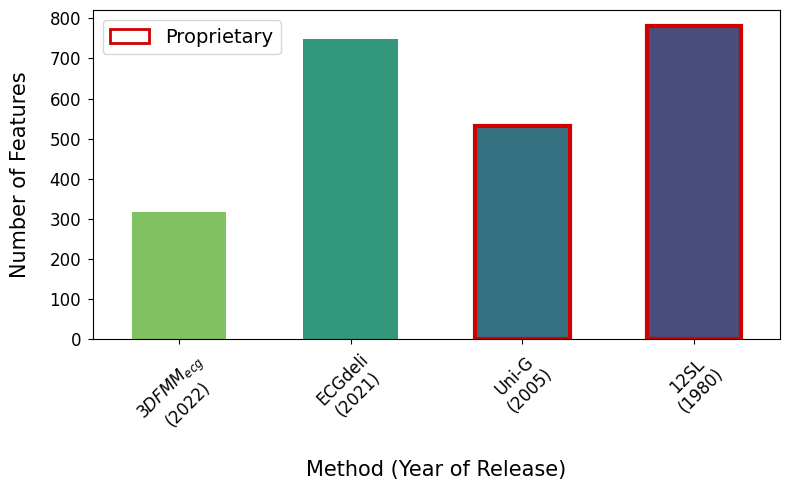

In [6]:
df_method_featnum = pd.DataFrame(method_featnum)
df_method_featnum["Method"] = df_method_featnum.apply(
    lambda row: (
        f"${{3DFMM_{{ecg}}}}$\n({row['ReleaseYear']})"
        if row["Method"] == "3DFMMecg"
        else f"{row['Method']}\n({row['ReleaseYear']})"
    ),
    axis=1,
)

palette = sns.color_palette("viridis", n_colors=4)
inverted_palette = palette[::-1]

plt.figure(figsize=(8, 5))
ax = sns.barplot(
    x="Method",
    y="Feature_Num",
    data=df_method_featnum,
    width=0.55,
    palette=inverted_palette,
)

for i, bar in enumerate(ax.patches):
    if i >= 2:
        bar.set_edgecolor("#d10000")
        bar.set_linewidth(3)

plt.xlabel("Method (Year of Release)")
plt.ylabel("Number of Features")
plt.xticks(rotation=45)


proprietary_patch = mpatches.Patch(
    edgecolor="#d10000", linewidth=2, facecolor="none", label="Proprietary"
)
plt.legend(handles=[proprietary_patch], loc="best")

plt.tight_layout()
plt.savefig("../img/feature_num.png", dpi=300, bbox_inches="tight")
plt.show()

## Age and sex

In [7]:
palette = {"Male": "#1500ff", "Female": "#ff0088"}

def plot_kde_with_medians(df, x_var, x_label, hue_var, palette, xlims, xticks, gridsize=500):
    """
    Plot KDE with medians for each group.
    """
    df_clean = df.dropna(subset=[x_var])
    df_clean["sex"] = df_clean["sex"].map({0: "Male", 1: "Female"})
    fig, ax = plt.subplots(figsize=(8, 5))
    
    # Plot KDE with thicker lines
    g = sns.kdeplot(data=df_clean, x=x_var, hue=hue_var, fill=True, common_norm=False, palette=palette, gridsize=gridsize, ax=ax, linewidth=2)
    
    # Calculate medians
    medians = df_clean.groupby(hue_var)[x_var].median()
    print(medians)
    # Add vertical lines for medians with thicker lines
    for hue, mean in medians.items():
        data = df_clean[df_clean[hue_var] == hue][x_var]
        kde = gaussian_kde(data, bw_method='scott')
        density_at_mean = kde.evaluate(mean)[0]
        ax.axvline(mean, linestyle='--', color=palette[hue], ymax=density_at_mean/ax.get_ylim()[1], linewidth=2)
    
    ax.set_xlabel(f"{x_label}")
    ax.set_ylabel("Density")
    ax.set_xlim(xlims)
    ax.set_xticks(np.arange(xlims[0], xlims[1] + 1, xticks))
    g.legend_.set_title(None)
    fig.tight_layout()
    plt.show()
    plt.close()
    fig.savefig(f"../img/kde_{x_var}.png", dpi=300, bbox_inches="tight")

sex
Female   64.000
Male     61.000
Name: age, dtype: float64


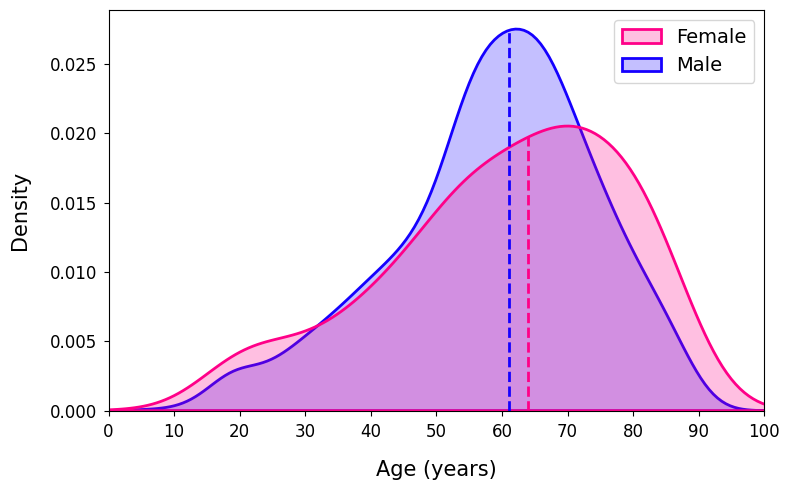

In [8]:
plot_kde_with_medians(X, x_var="age", x_label="Age (years)", hue_var="sex", palette=palette, xlims=(0, 100), xticks=10)

sex
Female   63.000
Male     77.000
Name: weight, dtype: float64


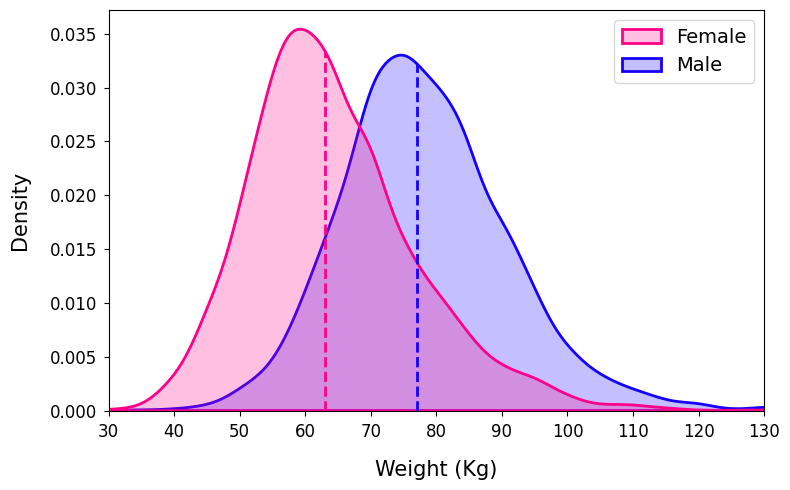

In [9]:
plot_kde_with_medians(X, x_var="weight", x_label="Weight (Kg)", hue_var="sex", palette=palette, xlims=(30, 130), xticks=10)

sex
Female   160.000
Male     174.000
Name: height, dtype: float64


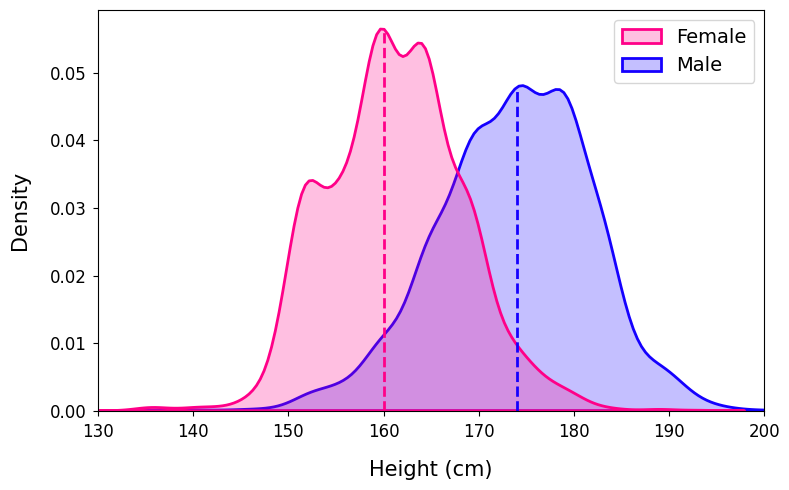

In [10]:
plot_kde_with_medians(X, x_var="height", x_label="Height (cm)", hue_var="sex", palette=palette, xlims=(130, 200), xticks=10)

## Superclass Venn diagram (Inkscape)

In [11]:
y_superdiag = pd.read_csv("../data/y_superdiag.csv").sort_values(by="ecg_id")
y_superdiag = y_superdiag.drop(columns=["ecg_id"])
y_superdiag = (y_superdiag > 0).astype(int)
y_superdiag.head()

,NORM,MI,STTC,HYP,CD
0,1,0,0,0,0
1,1,0,0,0,0
2,1,0,0,0,0
3,1,0,0,0,0
4,1,0,0,0,0


In [12]:
columns = ['NORM', 'MI', 'STTC', 'HYP', 'CD']
unique_values = {col: [0, 1] for col in columns}
all_combinations = list(product(*[unique_values[col] for col in columns]))
combinations_df = pd.DataFrame(all_combinations, columns=columns)
counts = y_superdiag.groupby(columns).size().reset_index(name='count')
result = combinations_df.merge(counts, on=columns, how='left').fillna(0)
result['count'] = result['count'].astype(int)
print(result)

    NORM  MI  STTC  HYP  CD  count
0      0   0     0    0   0    411
1      0   0     0    0   1   1708
2      0   0     0    1   0    535
3      0   0     0    1   1    300
4      0   0     1    0   0   2400
5      0   0     1    0   1    471
6      0   0     1    1   0    781
7      0   0     1    1   1    211
8      0   1     0    0   0   2532
9      0   1     0    0   1   1297
10     0   1     0    1   0    183
11     0   1     0    1   1    117
12     0   1     1    0   0    599
13     0   1     1    0   1    223
14     0   1     1    1   0    361
15     0   1     1    1   1    156
16     1   0     0    0   0   9069
17     1   0     0    0   1    407
18     1   0     0    1   0      2
19     1   0     0    1   1      2
20     1   0     1    0   0     28
21     1   0     1    0   1      5
22     1   0     1    1   0      0
23     1   0     1    1   1      0
24     1   1     0    0   0      0
25     1   1     0    0   1      0
26     1   1     0    1   0      0
27     1   1     0  

## Fold-wise table

In [13]:
y_superdiag_fold = y_superdiag.copy()
y_superdiag_fold["strat_fold"] = strat_fold
y_superdiag_fold["sex"]  = X["sex"]
y_superdiag_fold["age"]  = X["age"]
y_superdiag_fold["weight"]  = X["weight"]
y_superdiag_fold["height"]  = X["height"]

y_superdiag_fold.head()

,NORM,MI,STTC,HYP,CD,strat_fold,sex,age,weight,height
0,1,0,0,0,0,3,1,56.000,63.000,NaN
1,1,0,0,0,0,2,0,19.000,70.000,NaN
2,1,0,0,0,0,5,1,37.000,69.000,NaN
3,1,0,0,0,0,3,0,24.000,82.000,NaN
4,1,0,0,0,0,4,1,19.000,70.000,NaN


In [ ]:

df_fold = y_superdiag_fold.copy()

df_fold.loc[df_fold["age"] == 300, "age"] = 90 # 90+ are converted to 90
superclasses = sorted(['NORM', 'MI', 'STTC', 'HYP', 'CD'])
# Group by strat_fold
grouped = df_fold.groupby('strat_fold')
results = []
for fold, group in grouped:
    superclass_counts = group[superclasses].sum().to_dict()
    percentage_females = round(group['sex'].mean() * 100, 1)
    age_median = round(group['age'].median(), 1)
    results.append({
        'fold': fold,
        'Median age': f"{age_median}",
        'Female \%': percentage_females,
        **superclass_counts,
        
    })
results_df = pd.DataFrame(results)
results_df

,fold,Median age,Female \%,CD,HYP,MI,NORM,STTC
0,1,61.0,47.800,481,263,549,940,526
1,2,61.0,47.900,485,264,538,967,524
2,3,61.0,48.200,487,264,528,991,515
3,4,62.0,47.700,494,261,551,927,527
4,5,62.0,47.700,496,265,563,939,532
5,6,62.0,47.700,494,270,562,930,528
6,7,62.0,47.700,478,264,550,970,520
7,8,61.0,47.900,492,268,538,932,514
8,9,63.0,48.100,495,268,540,955,528
9,10,63.0,48.500,496,262,550,963,521


## FMM

In [10]:
# %%
LEADS = ["I", "II", "III", "aVR", "aVL", "aVF", "V1", "V2", "V3", "V4", "V5", "V6"]
WAVES = ["P", "Q", "R", "S", "T"]

#fmm = pd.read_csv("../data/datFinalV10_PTBXL.csv", sep=",")
fmm = pd.read_csv("../data/datFinalV10_PTBXL12leads.csv", sep=",")
fmm = fmm.rename(columns={"EcgId": "ecg_id", "BeatId": "beat_id"})
fmm = fmm.rename(
    columns=lambda x: re.sub("Alpha", "α_", x)
    if any(w in x for w in WAVES)
    else x
)
fmm = fmm.rename(
    columns=lambda x: re.sub("Beta", "β_", x)
    if any(w in x for w in WAVES)
    else x
)
fmm = fmm.rename(
    columns=lambda x: re.sub("Omega", "ω_", x)
    if any(w in x for w in WAVES)
    else x
)
fmm = fmm.rename(
    columns=lambda x: re.sub("^A", "A_", x)
    if any(l in x for l in LEADS)
    else x
)
fmm = fmm.rename(columns=lambda x: re.sub("R2", "R²", x))

m = [x for x in fmm.columns if re.findall("M_", x)]
alpha = [x for x in fmm.columns if re.findall("α", x)]
beta = [x for x in fmm.columns if re.findall("β", x)]
omega = [x for x in fmm.columns if re.findall("ω", x)]
amplitude = [x for x in fmm.columns if re.findall("A_", x)]
r2 = [x for x in fmm.columns if re.findall("R²", x)]
dist = [x for x in fmm.columns if re.findall("^d\w\w", x)]
fmm = fmm.loc[
    :, ["ecg_id", "beat_id", "Age", "Sex"] + alpha + beta + omega + amplitude + r2 + dist + m
]

print(fmm.shape)
fmm

(233124, 158)


,ecg_id,beat_id,Age,Sex,α_P,α_Q,α_R,α_S,α_T,β_P_I,...,M_V1,M_V2,M_V3,M_V4,M_V5,M_V6,M_III,M_aVR,M_aVL,M_aVF
0,1,2,56.000,1,5.010,5.637,5.777,5.911,1.375,3.722,...,-204.210,-264.460,38.621,161.165,266.678,303.716,-72.592,-312.716,210.802,101.914
1,1,3,56.000,1,5.055,5.660,5.788,5.929,1.378,3.751,...,-208.000,-220.299,81.181,175.520,286.370,283.620,-50.438,-293.652,184.655,108.997
2,1,4,56.000,1,5.012,5.625,5.759,5.892,1.322,3.469,...,-248.412,-277.124,65.247,198.815,297.306,347.992,-51.291,-298.695,187.816,110.879
3,1,5,56.000,1,4.973,5.608,5.740,5.874,1.294,3.788,...,-211.884,-233.831,67.932,175.810,280.153,328.385,-52.521,-301.586,190.184,111.402
4,1,6,56.000,1,5.020,5.630,5.757,5.895,1.304,3.618,...,-190.667,-182.766,90.970,187.477,268.697,314.513,-52.511,-346.741,212.754,133.987
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
233119,21837,5,68.000,0,4.969,5.606,5.718,5.832,1.010,4.275,...,-440.912,80.639,271.009,563.642,672.122,558.065,0.904,-487.999,243.322,244.677
233120,21837,6,68.000,0,4.939,5.611,5.729,5.838,0.992,4.391,...,-466.350,73.867,250.347,510.393,644.383,529.594,39.066,-433.513,187.457,246.056
233121,21837,7,68.000,0,4.954,5.633,5.731,5.844,1.031,4.341,...,-393.777,114.686,300.804,536.496,638.605,533.556,-43.370,-435.529,250.292,185.237
233122,21837,8,68.000,0,5.009,5.629,5.740,5.852,1.080,4.712,...,-394.259,40.405,244.462,536.155,678.298,536.693,33.008,-420.909,185.699,235.210


In [11]:
# Define the auxiliary functions
def phi(t, α, β, ω):
    return β + 2 * np.arctan(ω * np.tan((t - α) / 2))


def W(t, A, α, β, ω):
    return A * np.cos(phi(t, α, β, ω))

NOTE: The rest of the image is done with Draw.IO.

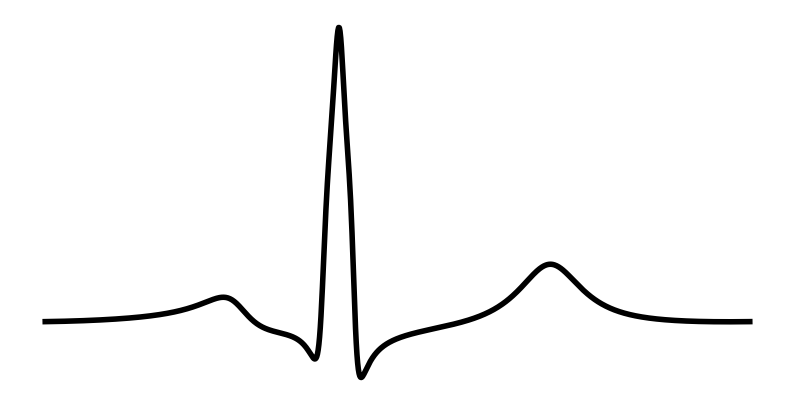

In [ ]:
def reconstruct_signal(fmm, lh, lead, t_values):
    ecg_healthy_id = lh.loc[
        (lh["NORM"] >= 80)
        & lh["MI"].isna()
        & lh["STTC"].isna()
        & lh["HYP"].isna()
        & lh["CD"].isna(),
        "ecg_id",
    ].values

    row = fmm.loc[fmm["ecg_id"].isin(ecg_healthy_id), :].apply(lambda x: x.median())

    if row.empty:
        raise ValueError("No data found for the given ecg_id and beat_id")

    # Initialize the reconstructed signal and individual wave components
    reconstructed_signal = np.zeros_like(t_values)
    wave_components = {wave: np.zeros_like(t_values) for wave in WAVES}

    # Compute the signal reconstruction for the specified lead
    M_L = row[f"M_{lead}"]
    for wave in WAVES:
        A_J = row[f"A_{wave}_{lead}"]
        α_J = row[f"α_{wave}"]
        β_J = row[f"β_{wave}_{lead}"]
        ω_J = row[f"ω_{wave}"]

        # Artificially increase the amplitude for Q and S waves for better visualization
        if wave in ["Q"]:
            A_J += 150
        if wave in ["S"]:
            A_J += 200

        wave_components[wave] = W(t_values, A_J, α_J, β_J, ω_J)

        reconstructed_signal += wave_components[wave]

    # reconstructed_signal += M_L

    return reconstructed_signal, wave_components


# Example usage
t_values = np.linspace(0, 2 * np.pi, 1000)  # Example time values
lead = "II"  # Specify the lead name
y_superdiag_lh = pd.read_csv("../data/y_superdiag.csv").sort_values(by="ecg_id")
reconstructed_signal, wave_components = reconstruct_signal(
    fmm, y_superdiag_lh, lead, t_values
)

# Plot the reconstructed signal for the specified lead
plt.figure(figsize=(10, 5))
plt.plot(
    t_values, reconstructed_signal, label=f"Lead {lead}", linewidth=4, color="black"
)
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.axis("off")
plt.savefig("../img/fmm-wave.png", dpi=300, bbox_inches="tight", transparent=True)
plt.show()

In [14]:
def reconstruct_signal(fmm, ecg_id, beat_id, lead, t_values):
    row = fmm[(fmm['ecg_id'] == ecg_id) & (fmm['beat_id'] == beat_id)]
    if row.empty:
        raise ValueError("No data found for the given ecg_id and beat_id")
    
    # Initialize the reconstructed signal and individual wave components
    wave_components = {wave: np.zeros_like(t_values) for wave in WAVES}
    
    # Compute the signal reconstruction for the specified lead
    M_L = row[f'M_{lead}'].values[0]
    for wave in WAVES:
        A_J = row[f'A_{wave}_{lead}'].values[0]
        α_J = row[f'α_{wave}'].values[0]
        β_J = row[f'β_{wave}_{lead}'].values[0]
        ω_J = row[f'ω_{wave}'].values[0]
        
        wave_components[wave] = W(t_values, A_J, α_J, β_J, ω_J)
    
    return wave_components, M_L

# Define the function to plot the decomposed waves for all leads
def plot_decomposed_waves(fmm, ecg_id, beat_id, t_values, data, path, plot_original_and_predicted=False):
    PALETTE = {
        "P": "#720ec4", # purple 
        "Q": "#2e9c19", # green 
        "R": "#d60b0b", # red
        "S": "#de5f04", # orange
        "T": "#1583d1", # blue
    }
    fig, axes = plt.subplots(2, 6, figsize=(22, 6))
    axes = axes.flatten()
    PRED_COLOR = '#d400b1'
    for i, lead in enumerate(LEADS):
        wave_components, M_L = reconstruct_signal(fmm, ecg_id, beat_id, lead, t_values)
        
        if plot_original_and_predicted:
            # Plot the true signal from the data DataFrame
            true_signal = data[:, i]
            axes[i].plot(t_values, true_signal, label='True Signal', linewidth=3, color='black')
            
            # Plot the predicted signal (sum of the waves)
            predicted_signal = np.sum(list(wave_components.values()), axis=0) + M_L
            predicted_signal /= 1_000
            shift = [0, 0.05, 0.02, -0.04, 0, 0.035, 0, 0, 0, 0, 0, 0]
            predicted_signal = predicted_signal + shift[i]
            axes[i].plot(t_values, predicted_signal, label='Predicted Signal', linewidth=4, color=PRED_COLOR)
        else:
            for wave, signal in wave_components.items():
                axes[i].plot(t_values, signal - np.median(signal), label=f'{wave} wave', linewidth=4, color=PALETTE[wave])
        
        lead_label = f'{lead}$^+$' if lead in ["aVR", "aVL", "aVF"] else lead
        axes[i].set_title(f'{lead_label}', loc='left')
        axes[i].tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
        axes[i].spines['top'].set_visible(True)
        axes[i].spines['right'].set_visible(True)
        axes[i].spines['bottom'].set_visible(True)
        axes[i].spines['left'].set_visible(True)

        # Make the axis borders thicker
        for spine in axes[i].spines.values():
            spine.set_linewidth(0)

        axes[i].xaxis.set_major_locator(MaxNLocator(nbins=30))
        axes[i].yaxis.set_major_locator(MaxNLocator(nbins=30))

        axes[i].grid(True, which='both', color='#FFDDC1', linestyle='-', linewidth=1.5)

    if plot_original_and_predicted:
        handles = [
            plt.Line2D([0], [0], color='black', lw=6, label='Observed Signal'),
            plt.Line2D([0], [0], color=PRED_COLOR, lw=6, label='Predicted Signal')
        ]
    else:
        handles = [plt.Line2D([0], [0], color=PALETTE[wave], lw=6, label=wave) for wave in WAVES]
    
    fig.legend(handles=handles, loc='lower center', ncol=len(handles), bbox_to_anchor=(0.5, -0.1), fontsize=24, frameon=False)

    plt.tight_layout()
    plt.savefig(path, dpi=300, bbox_inches="tight", transparent=False)
    plt.show()

In [8]:
data, meta = wfdb.rdsamp("../data/00001_hr")
data = data[1776:2244,:] # Select a specific beat
t_values = np.linspace(0, 2 * np.pi, len(data))
ecg_id = 1
beat_id = 5
LEADS = ["I", "II", "III", "aVR", "aVL", "aVF", "V1", "V2", "V3", "V4", "V5", "V6"]
WAVES = ["P", "Q", "R", "S", "T"]

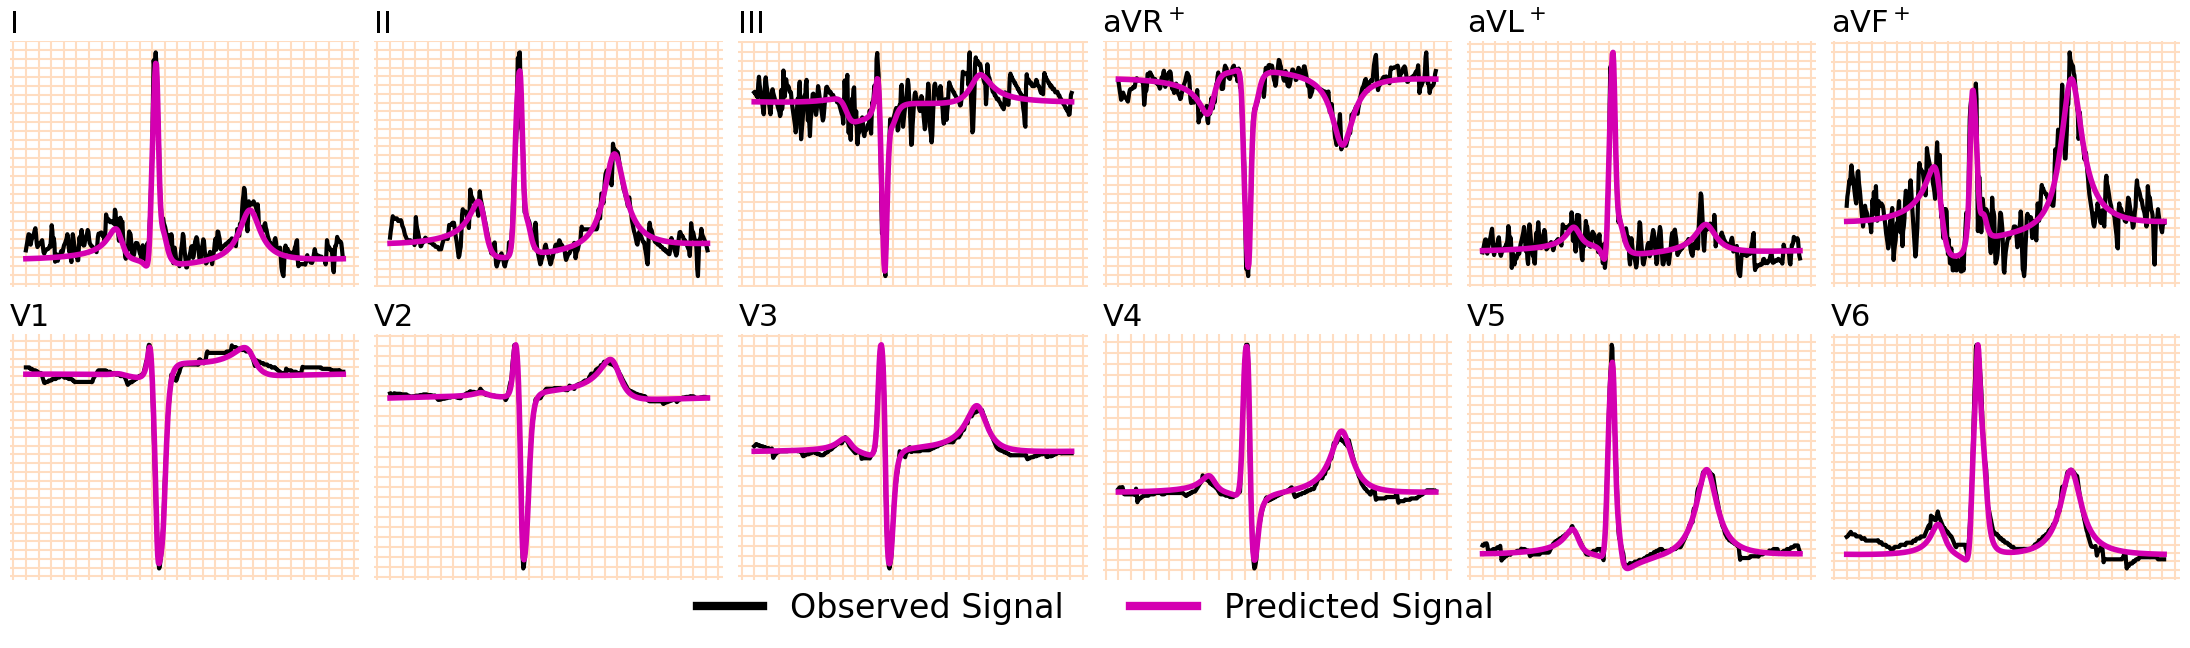

In [12]:
plot_decomposed_waves(fmm, ecg_id, beat_id, t_values, data, "../img/3dfmm-signal.png", plot_original_and_predicted=True)

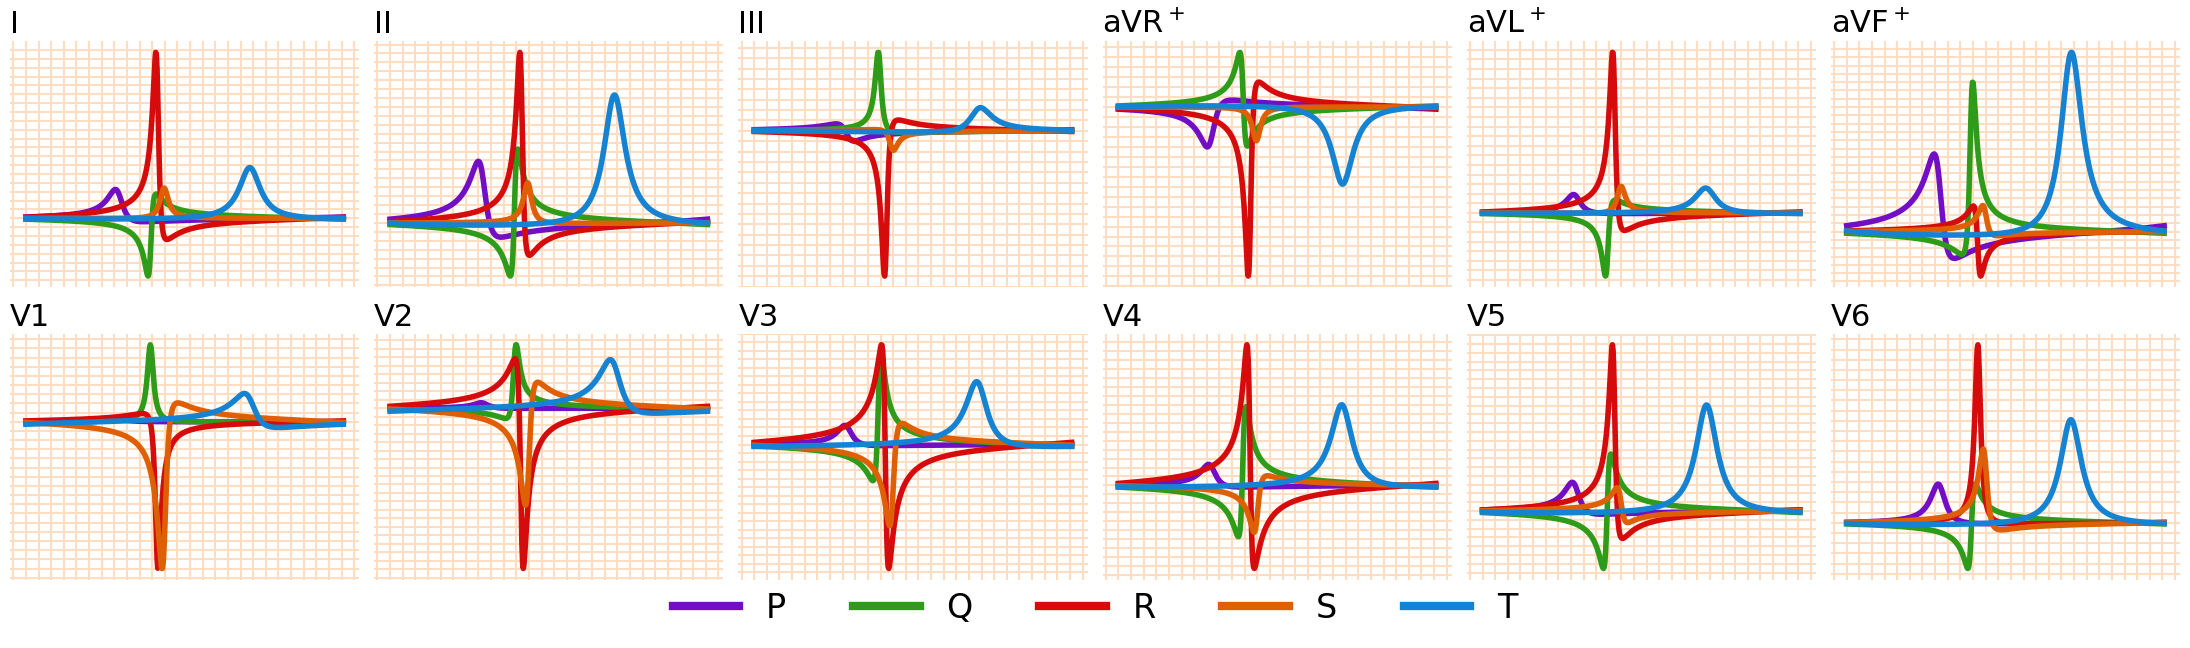

In [15]:
plot_decomposed_waves(fmm, ecg_id, beat_id, t_values, data, "../img/3dfmm-decomp.png", plot_original_and_predicted=False)

## Dimensionality reduction

In [15]:
imputer = SimpleImputer(strategy='median')
X_imputed = imputer.fit_transform(X)

In [16]:
def plot_dimensionality_reduction(X, y, method="PCA", palette=None, marker_size=15):
    """
    Plot the dimensionality reduction of the input data using PCA, t-SNE or UMAP.
    """
    # Define color palette
    palette = palette or {
        "CD": "#1583d1",
        "HYP": "#de5f04",
        "MI": "#d60b0b",
        "NORM": "#2e9c19",
        "STTC": "#720ec4",
    }

    # Preprocess data if needed
    X = StandardScaler().fit_transform(X)

    if method == "PCA":
        reducer = PCA(n_components=2)
        components = ["PCA1", "PCA2"]
    elif method == "t-SNE":
        reducer = TSNE(n_components=2, random_state=42)
        components = ["TSNE1", "TSNE2"]
    elif method == "UMAP":
        reducer = umap.UMAP(n_components=2, random_state=42)
        components = ["UMAP1", "UMAP2"]
    else:
        raise ValueError("Unsupported method. Use 'pca', 'tsne' or 'umap'.")

    X_reduced = reducer.fit_transform(X)
    df_reduced = pd.DataFrame(X_reduced, columns=components)
    df_reduced["label"] = y["label"]

    # Create the scatter plot using seaborn
    fig, ax = plt.subplots(figsize=(8, 5))
    scatter_plot = sns.scatterplot(
        data=df_reduced,
        x=components[0],
        y=components[1],
        hue="label",
        palette=palette,
        s=marker_size,
        edgecolor="w",
        linewidth=0.5,
    )
    q_low_1 = 0.0005
    q_high_1 = 0.995
    q_low_2 = 0.0009
    q_high_2 = 0.9995
    comp1_min = df_reduced[components[0]].quantile(q_low_1)
    comp1_max = df_reduced[components[0]].quantile(q_high_1)
    comp2_min = df_reduced[components[1]].quantile(q_low_2)
    comp2_max = df_reduced[components[1]].quantile(q_high_2)

    ax.set_xlabel(f"Component 1")
    ax.set_ylabel(f"Component 2")
    ax.set_xlim(comp1_min, comp1_max)
    ax.set_ylim(comp2_min, comp2_max)

    handles = [
        Line2D(
            [0],
            [0],
            marker="o",
            color="w",
            label=label,
            markersize=8,
            markerfacecolor=color,
        )
        for label, color in palette.items()
    ]

    ax.legend(
        handles=handles,
        fontsize="10",
        loc="best",
        # bbox_to_anchor=(1.04, 1.06),
        # borderaxespad=2.5,
    )
    fig.set_size_inches(8, 5)
    plt.grid(False)
    plt.close(fig)  # Prevent the figure from being displayed
    return fig

### PCA

In [17]:
fig_pca = plot_dimensionality_reduction(X_imputed, y, method='PCA')

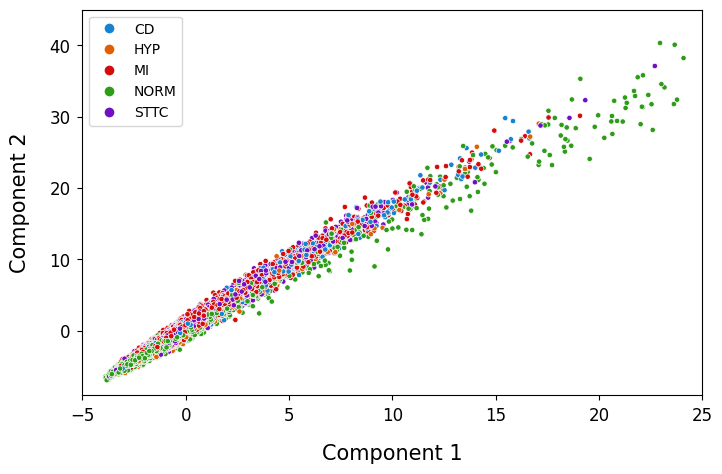

In [18]:
fig_pca.axes[0].set_xlim((-5,25))
fig_pca.axes[0].set_ylim((-9,45))
fig_pca.savefig('../img/pca.png', dpi=300, bbox_inches='tight', pad_inches=0.1)
fig_pca

### t-SNE

In [19]:
fig_tsne =  plot_dimensionality_reduction(X_imputed, y, method='t-SNE')

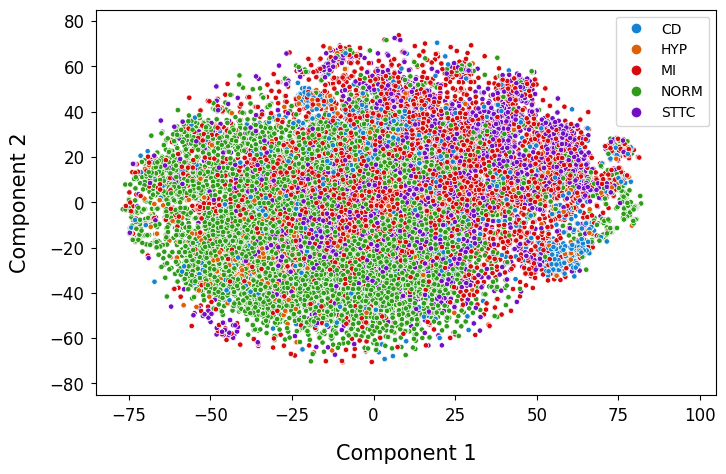

In [20]:
fig_tsne.axes[0].set_xlim((-85,105))
fig_tsne.axes[0].set_ylim((-85,85))
fig_tsne.savefig('../img/tsne.png', dpi=300, bbox_inches='tight', pad_inches=0.1)
fig_tsne

### UMAP

In [21]:
fig_umap =  plot_dimensionality_reduction(X_imputed, y, method='UMAP')

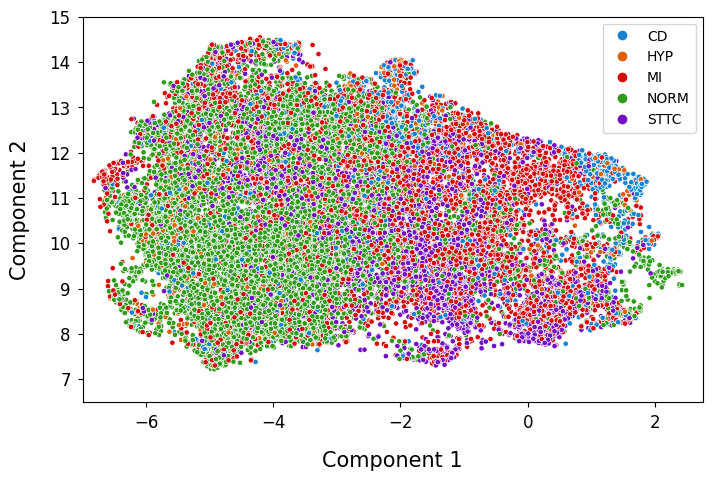

In [22]:
fig_umap.axes[0].set_xlim((-7, 2.75))
fig_umap.axes[0].set_ylim((6.5, 15))
fig_umap.savefig('../img/umap.png', dpi=300, bbox_inches='tight', pad_inches=0.1)
fig_umap

## Benchmark Table

In [ ]:
def extract_metrics_from_model_names(models_folder):
    """
    Extracts metrics from the model names in the specified folder.
    """
    rows = []
    for filename in os.listdir(models_folder):
        if filename.endswith(".pkl"):
            match = re.match(
                r"(.+?)_(.+?)_(.+?)\.(.+?)\.(.+?)\.(.+?)\.(.+?)\.pkl", filename
            )
            if match:
                (
                    problem,
                    feature_method,
                    model_name,
                    macro_auc,
                    weighted_macro_auc,
                    instance_auc,
                    weighted_instance_auc,
                ) = match.groups()
                macro_auc = float("0." + macro_auc)
                weighted_macro_auc = float("0." + weighted_macro_auc)
                instance_auc = float("0." + instance_auc)
                weighted_instance_auc = float("0." + weighted_instance_auc)
                rows.append(
                    [
                        problem,
                        feature_method,
                        model_name,
                        macro_auc,
                        weighted_macro_auc,
                        instance_auc,
                        weighted_instance_auc,
                    ]
                )
    metrics_df = pd.DataFrame(
        rows,
        columns=[
            "Problem",
            "Method",
            "Model Name",
            "Macro AUC",
            "Weighted Macro AUC",
            "Instance AUC",
            "Weighted Instance AUC",
        ],
    )
    return metrics_df

In [ ]:
models_folder = "../models"
metrics_df = extract_metrics_from_model_names(models_folder)

desired_order = ["3dfmmecg","unig", "12sl", "ecgdeli"]
desired_problem_order = ["all", "diag", "subdiag", "superdiag", "form", "rhythm"]

metrics = ["Macro AUC", "Weighted Macro AUC", "Instance AUC", "Weighted Instance AUC"]
pivot_tables = {}

for metric in metrics:
    pivot_table = metrics_df.pivot_table(
        index="Method", columns="Problem", values=metric, aggfunc="mean"
    )
    pivot_table = pivot_table.reindex(
        index=desired_order, columns=desired_problem_order
    )
    pivot_table = pivot_table.round(3)
    pivot_tables[metric] = pivot_table

custom_values = [0.925, 0.937, 0.929, 0.928, 0.896, 0.957]
pivot_tables["Macro AUC"].loc["CNN/raw data"] = custom_values

cmap = sns.diverging_palette(10, 150, as_cmap=True)
latex = []
for metric, pivot_table in pivot_tables.items():
    print(f"############################### {metric} ###############################")
    styled_pivot_table = pivot_table.style.format("{:.3f}").background_gradient(
        cmap=cmap
    )
    display(styled_pivot_table)
    latex.append(styled_pivot_table.to_latex())
    print("\n\n")

############################### Macro AUC ###############################


Problem,all,diag,subdiag,superdiag,form,rhythm
Method,,,,,,
3dfmmecg,0.891,0.883,0.894,0.936,0.910,0.948
unig,0.863,0.892,0.888,0.907,0.803,0.906
12sl,0.854,0.887,0.854,0.925,0.786,0.840
ecgdeli,0.868,0.885,0.884,0.896,0.761,0.958
CNN/raw data,0.925,0.937,0.929,0.928,0.896,0.957





############################### Weighted Macro AUC ###############################


Problem,all,diag,subdiag,superdiag,form,rhythm
Method,,,,,,
3dfmmecg,0.896,0.892,0.898,0.942,0.911,0.948
unig,0.869,0.900,0.894,0.916,0.803,0.906
12sl,0.860,0.896,0.862,0.933,0.786,0.840
ecgdeli,0.872,0.892,0.887,0.908,0.761,0.958





############################### Instance AUC ###############################


Problem,all,diag,subdiag,superdiag,form,rhythm
Method,,,,,,
3dfmmecg,0.967,0.941,0.936,0.910,0.377,0.940
unig,0.946,0.922,0.908,0.843,0.350,0.926
12sl,0.966,0.950,0.924,0.905,0.361,0.937
ecgdeli,0.964,0.933,0.930,0.885,0.358,0.941





############################### Weighted Instance AUC ###############################


Problem,all,diag,subdiag,superdiag,form,rhythm
Method,,,,,,
3dfmmecg,0.969,0.942,0.936,0.910,0.377,0.940
unig,0.948,0.923,0.907,0.846,0.350,0.926
12sl,0.968,0.951,0.924,0.906,0.361,0.937
ecgdeli,0.966,0.933,0.930,0.886,0.358,0.941


## SHAP

### Global Feature Importances

In [27]:
problem_importances = defaultdict(lambda: defaultdict(float))
MODELS_DIR = "../models/"

for filename in os.listdir(MODELS_DIR):
    if filename.startswith(
        (
            "all_3dfmmecg",
            "diag_3dfmmecg",
            "subdiag_3dfmmecg",
            "superdiag_3dfmmecg",
            "form_3dfmmecg",
            "rhythm_3dfmmecg",
        )
    ):
        print(filename)
        model_path = os.path.join(MODELS_DIR, filename)
        model = PTBXLModel.load(model_path)
        
        # Create explainers for each model
        explainers = model.build_shap_explainer(shap.TreeExplainer)

        # Calculate feature importances using SHAP values
        for target, explainer in explainers.items():
            shap_values = explainer.shap_values(X_test)
            feature_importances = np.abs(shap_values[:,:,1]).mean(axis=0)
            for feature, importance in zip(X_test.columns, feature_importances):
                problem_importances[filename][feature] += importance

# Convert the dictionary to a DataFrame
problem_importances_df = pd.DataFrame(problem_importances).fillna(0)

all_3dfmmecg_RandomForestClassifier.891.896.967.969.pkl
diag_3dfmmecg_RandomForestClassifier.883.892.941.942.pkl
form_3dfmmecg_RandomForestClassifier.910.911.377.377.pkl
rhythm_3dfmmecg_RandomForestClassifier.948.948.940.940.pkl
subdiag_3dfmmecg_RandomForestClassifier.894.898.936.936.pkl
superdiag_3dfmmecg_RandomForestClassifier.936.942.910.910.pkl


In [28]:
def process_and_plot(problem_importances_df, items, path, underscore_position="both"):
    """
    Process the feature importances DataFrame and plot the top features for each problem.
    """
    problem_importances_df.columns = problem_importances_df.columns.str.replace(
        r"(_.*)", "", regex=True
    )
    rename_dict = {"subdiag": "sub-diag.", "superdiag": "super-diag."}
    problem_importances_df = problem_importances_df.rename(columns=rename_dict)

    for item in items:
        if item.startswith("dR"):
            pattern = f"{item[0:2]}[A-Z]_"  # Match dR followed by any uppercase letter
        elif underscore_position == "start":
            pattern = f"_{item}"
        elif underscore_position == "end":
            pattern = f"{item}_"
        else:
            pattern = f"_{item}_"

        suma = problem_importances_df[
            problem_importances_df.index.str.contains(pattern)
        ].sum()
        problem_importances_df = pd.concat(
            [problem_importances_df, pd.DataFrame([suma], index=[item])]
        )
        problem_importances_df = problem_importances_df[
            ~problem_importances_df.index.str.contains(pattern)
        ]

    top_features_per_problem = {}
    for problem in problem_importances_df.columns:
        top_features = problem_importances_df.loc[items, problem]
        top_features_per_problem[problem] = top_features

    normalized_df = pd.DataFrame()
    for problem, features in top_features_per_problem.items():
        normalized_df[problem] = features / features.sum() * 100
    print(normalized_df)
    # Reorder columns and rename them
    order = ["all", "diag", "sub-diag.", "super-diag.", "form", "rhythm"]
    normalized_df = normalized_df[order]

    fig, ax = plt.subplots(figsize=(12, 8))
    bar_width = 0.5
    bar_positions = np.arange(len(normalized_df.columns))
    bottoms = np.zeros(len(normalized_df.columns))

    # Custom color palette
    colors = [
        "#9467bd",  # Purple
        "#2ca02c",  # Green
        "#d62728",  # Red
        "#ff7f0e",  # Orange
        "#1f77b4",  # Blue
        "#8c564b",  # Brown
        "#e377c2",  # Pink
        "#7f7f7f",  # Gray
        "#bcbd22",  # Olive
        "#17becf",  # Cyan
        "#aec7e8",  # Light Blue
        "#ffbb78",  # Light Orange
    ]

    for i, item in enumerate(items):
        bars = ax.bar(
            bar_positions,
            normalized_df.loc[item],
            bar_width,
            label=item.replace("dR", "dRJ'"),
            bottom=bottoms,
            color=colors[i % len(colors)],
            edgecolor="white",
            linewidth=2,
        )
        bottoms += normalized_df.loc[item]

    ax.set_xlabel("Problem")
    ax.set_ylabel("Importance (%)")

    # Set x-tick labels
    xtick_labels = ["all", "diag", "sub-diag.", "super-diag.", "form", "rhythm"]
    ax.set_xticks(bar_positions)
    ax.set_xticklabels(xtick_labels)

    ax.set_yticks(np.arange(0, 110, 10))

    # Reverse the order of the legend to match the bar colors from bottom to top
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles[::-1], labels[::-1], bbox_to_anchor=(1, 1), loc="upper left")

    plt.tight_layout()
    plt.savefig(path, dpi=300, bbox_inches="tight")
    plt.show()

       all   diag   form  rhythm  sub-diag.  super-diag.
I    9.438  9.012 10.467   7.746      8.705        9.510
II  10.974 11.114 11.143  15.281     11.485       14.326
III  5.992  5.398  5.959   5.755      5.789        4.900
aVR  8.006  6.687  9.470  11.199      7.353        9.401
aVL  5.984  5.392  6.589   7.039      5.283        4.473
aVF  7.375  7.248  7.413   7.624      7.664        6.745
V1   7.082  7.899  4.240   6.507      8.379        7.325
V2   7.065  7.616  5.360   4.938      7.532        4.994
V3   7.176  7.107  5.850   4.972      6.430        4.647
V4   7.204  7.701  7.588   6.394      7.262        7.242
V5  11.429 11.924 12.921   9.903     11.462       12.690
V6  12.275 12.903 12.999  12.641     12.656       13.747


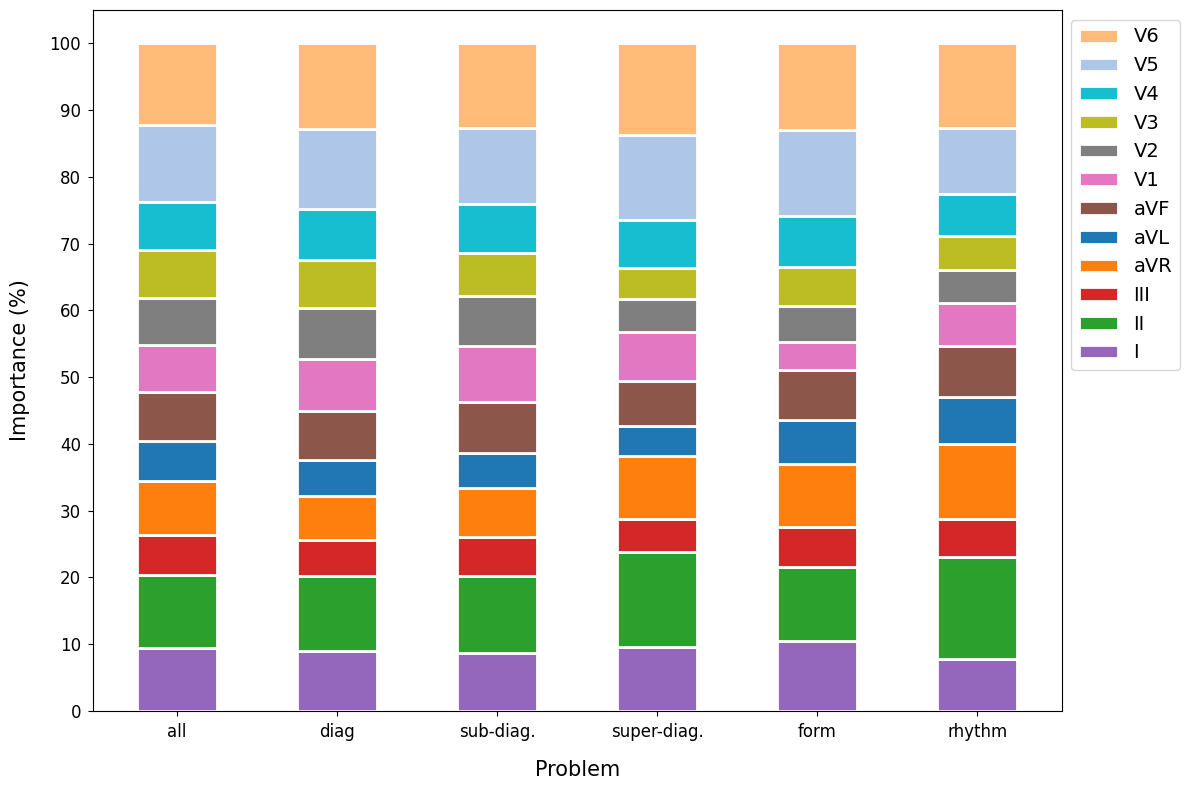

In [29]:
leads = ["I", "II", "III", "aVR", "aVL", "aVF", "V1", "V2", "V3", "V4", "V5", "V6"]
process_and_plot(
    problem_importances_df,
    leads,
    "../img/imp_stacked_lead.png",
    underscore_position="both",
)


     all   diag   form  rhythm  sub-diag.  super-diag.
P 15.473  9.923 12.129  40.300      9.991        7.813
Q 13.681 12.791 11.030  10.849     12.704       10.523
R 23.525 24.859 23.039  16.035     24.307       22.711
S 10.537 10.168  7.762  10.844     10.918       10.807
T 36.784 42.259 46.040  21.973     42.081       48.146


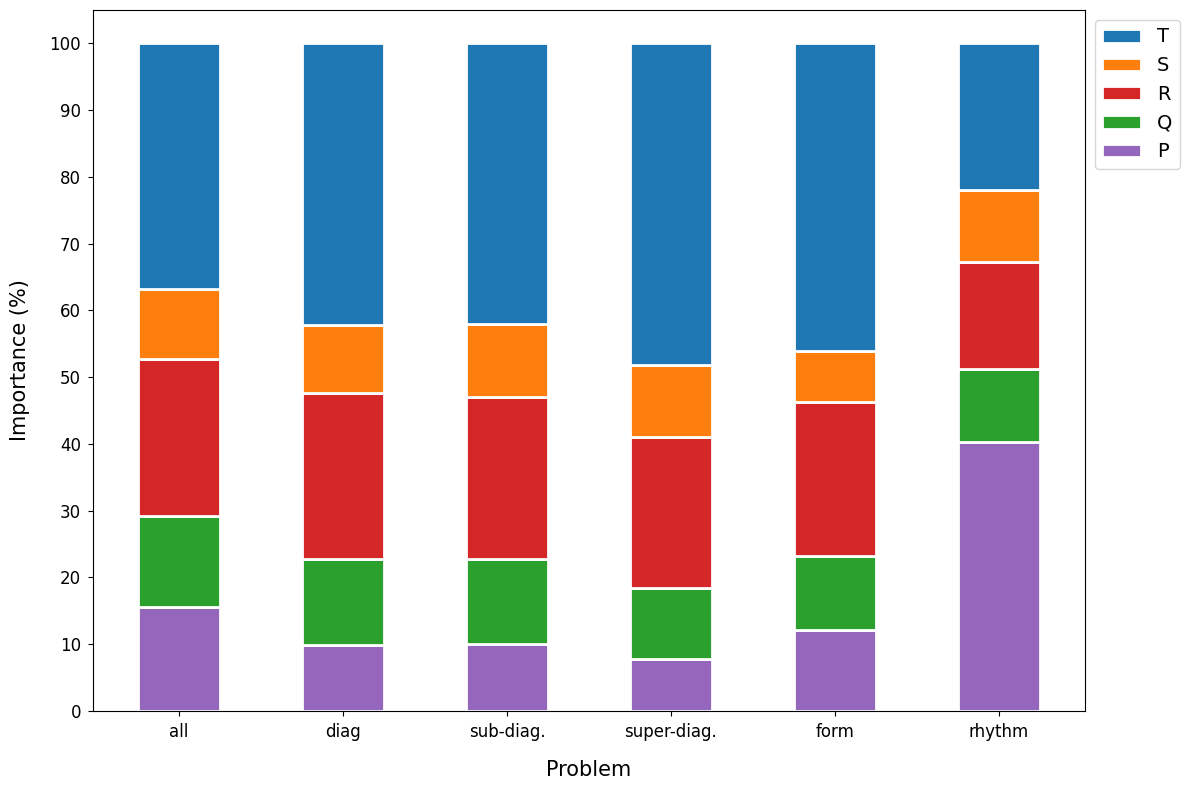

In [30]:
waves = ["P", "Q", "R", "S", "T"]
process_and_plot(problem_importances_df, waves, "../img/imp_stacked_wave.png", underscore_position='both')

      all   diag   form  rhythm  sub-diag.  super-diag.
M   9.248 11.651  8.234   3.349     11.884       12.442
A  28.126 29.310 38.760  21.219     29.665       32.496
α   4.891  2.705  3.945  16.323      2.930        2.310
β  46.713 45.844 40.140  36.856     45.183       41.610
ω   3.553  3.564  3.649   6.430      3.604        4.109
R²  3.148  3.449  2.344   4.269      3.146        2.387
dR  4.321  3.476  2.926  11.553      3.587        4.646


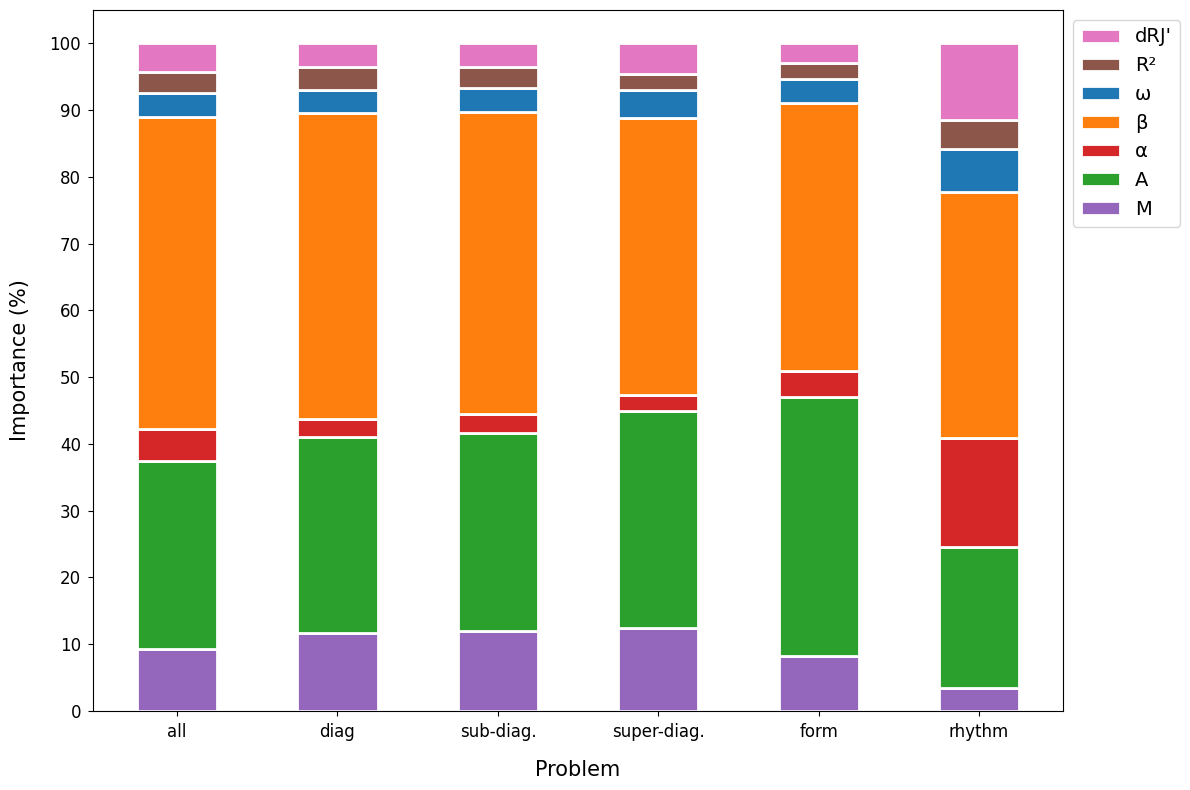

In [31]:
parameters = ["M", "A", "α", "β", "ω", "R²", "dR"]
process_and_plot(problem_importances_df, parameters, "../img/imp_stacked_param.png", underscore_position='end')

### Superclass Explanations

In [14]:
MODELS_DIR = "../models/"
model = None
for filename in os.listdir(MODELS_DIR):
    if filename.startswith(("superdiag_3dfmmecg")):
        model_path = os.path.join(MODELS_DIR, filename)
        model = load(model_path)
explainers  = model.build_shap_explainer(shap.TreeExplainer)

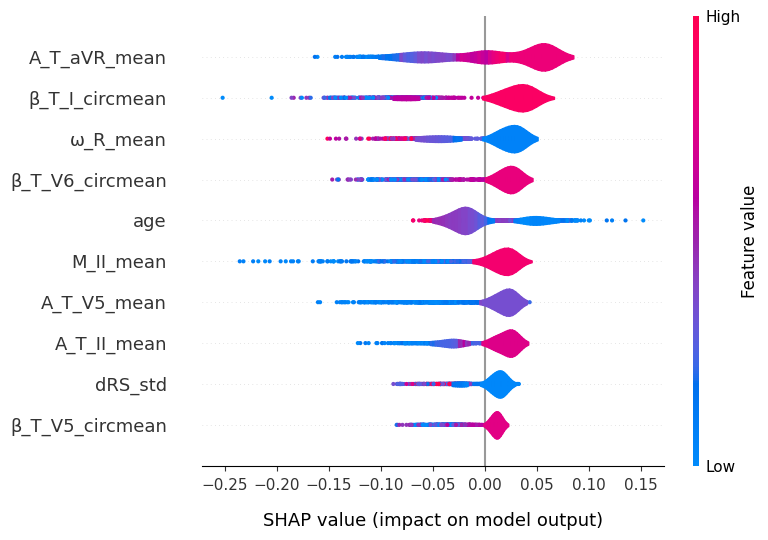

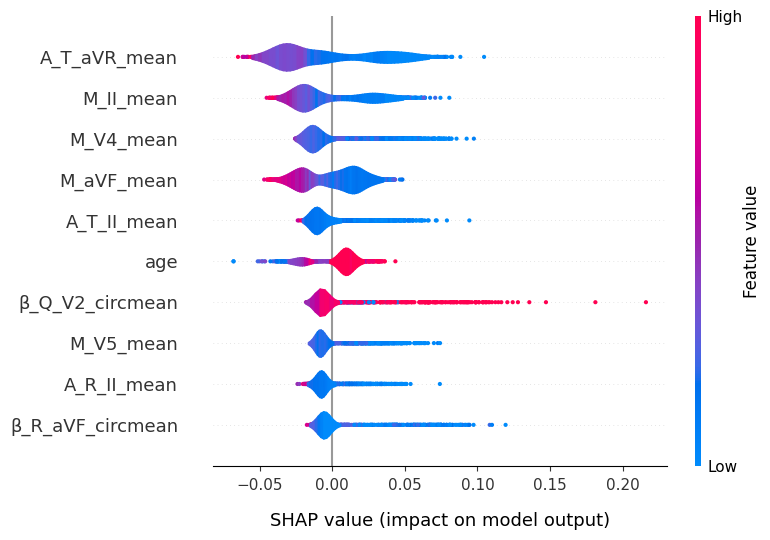

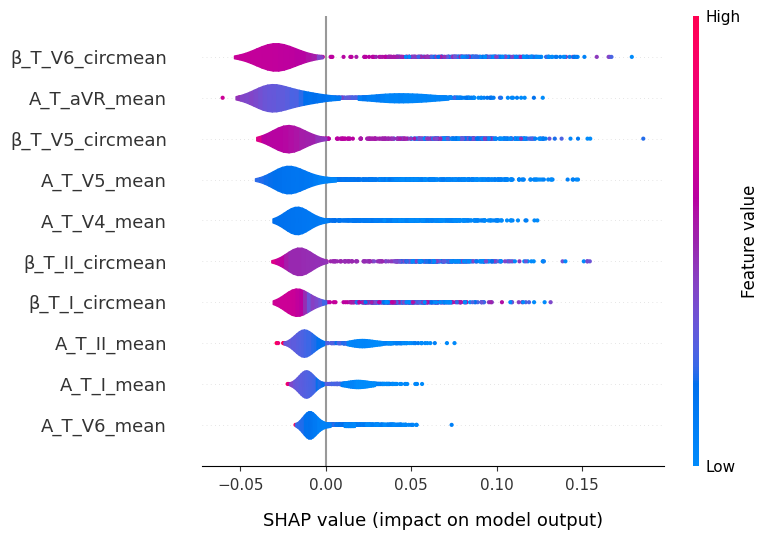

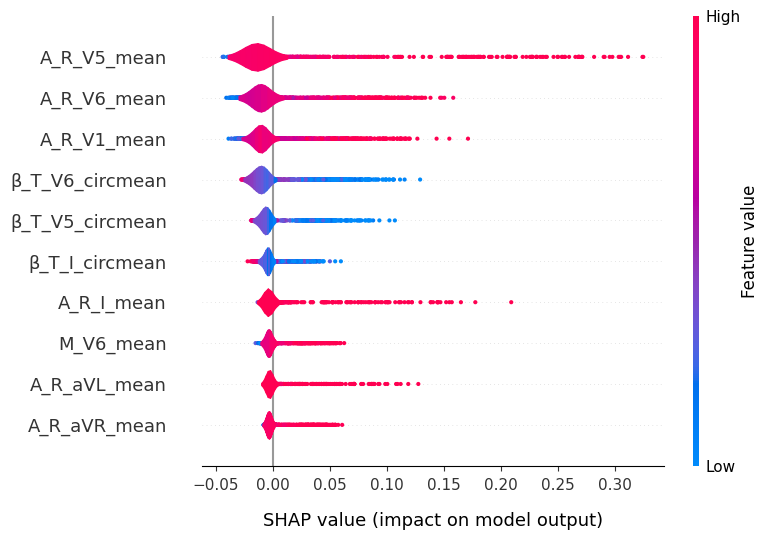

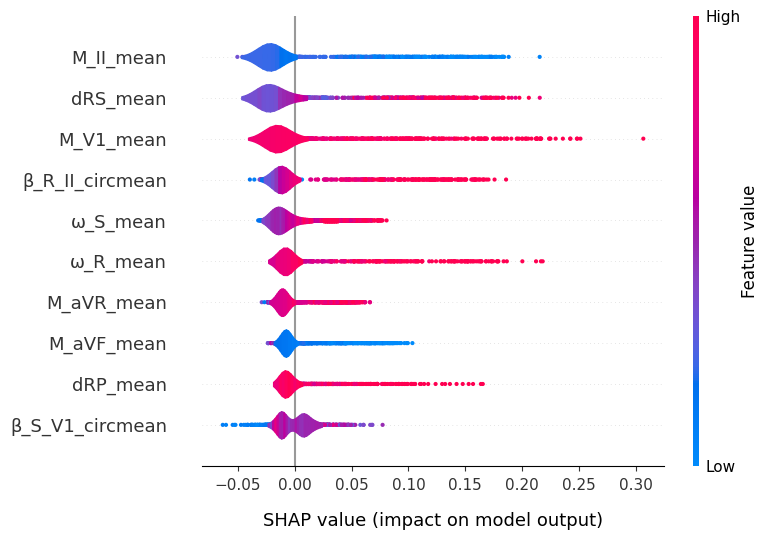

In [15]:
POSITIVE_CLASS = 1

encoder = model.get_encoder()
X_test_encoded = pd.DataFrame(encoder.transform(X_test), columns=X_test.columns)
shap_values_dict = {}
for i, name in enumerate(explainers):
    explainer = explainers[name]
    shap_values = explainer.shap_values(X_test_encoded)
    shap_values_dict[name] = shap_values
    shap.summary_plot(shap_values[:,:,POSITIVE_CLASS], X_test_encoded, plot_type="violin", max_display=10,show=False)
    
    plt.savefig(f"../img/shap_summary_plot{i}_{name}.png", dpi=300, bbox_inches='tight')
    plt.show()

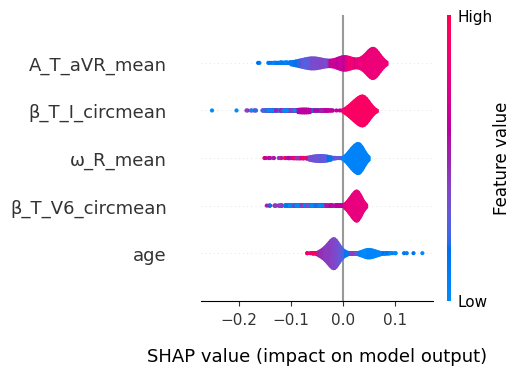

In [25]:
name = "NORM"
shap.summary_plot(shap_values_dict[name][:,:,POSITIVE_CLASS], X_test_encoded, plot_type="violin", max_display=5,show=False)
plt.gcf().set_size_inches(4, 4)
plt.savefig(f"../img/shap_summary_plot_{name}_crop.png", dpi=300, bbox_inches='tight')
plt.show()

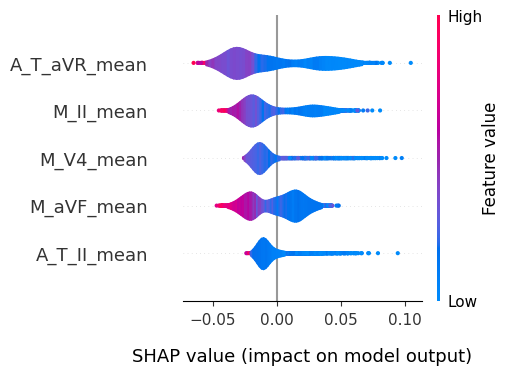

In [26]:
name = "MI"
shap.summary_plot(shap_values_dict[name][:,:,POSITIVE_CLASS], X_test_encoded, plot_type="violin", max_display=5,show=False)
plt.gcf().set_size_inches(4, 4)
plt.savefig(f"../img/shap_summary_plot_{name}_crop.png", dpi=300, bbox_inches='tight')
plt.show()

### Local Explanation

In [20]:
y_superdiag_lh_test = pd.read_csv("../data/y_superdiag.csv").sort_values(by="ecg_id")
y_superdiag_lh_test = y_superdiag_lh_test.loc[y_superdiag_lh["ecg_id"].isin(test_idx),:].reset_index(drop=True)
y_superdiag_lh_test

,ecg_id,NORM,MI,STTC,HYP,CD
0,9,100.000,NaN,NaN,NaN,NaN
1,38,100.000,NaN,NaN,NaN,NaN
2,40,80.000,NaN,NaN,NaN,NaN
3,57,100.000,NaN,NaN,NaN,NaN
4,59,100.000,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...
2193,21809,100.000,NaN,NaN,NaN,NaN
2194,21812,NaN,NaN,NaN,NaN,100.000
2195,21818,100.000,NaN,NaN,NaN,NaN
2196,21819,NaN,NaN,NaN,NaN,100.000


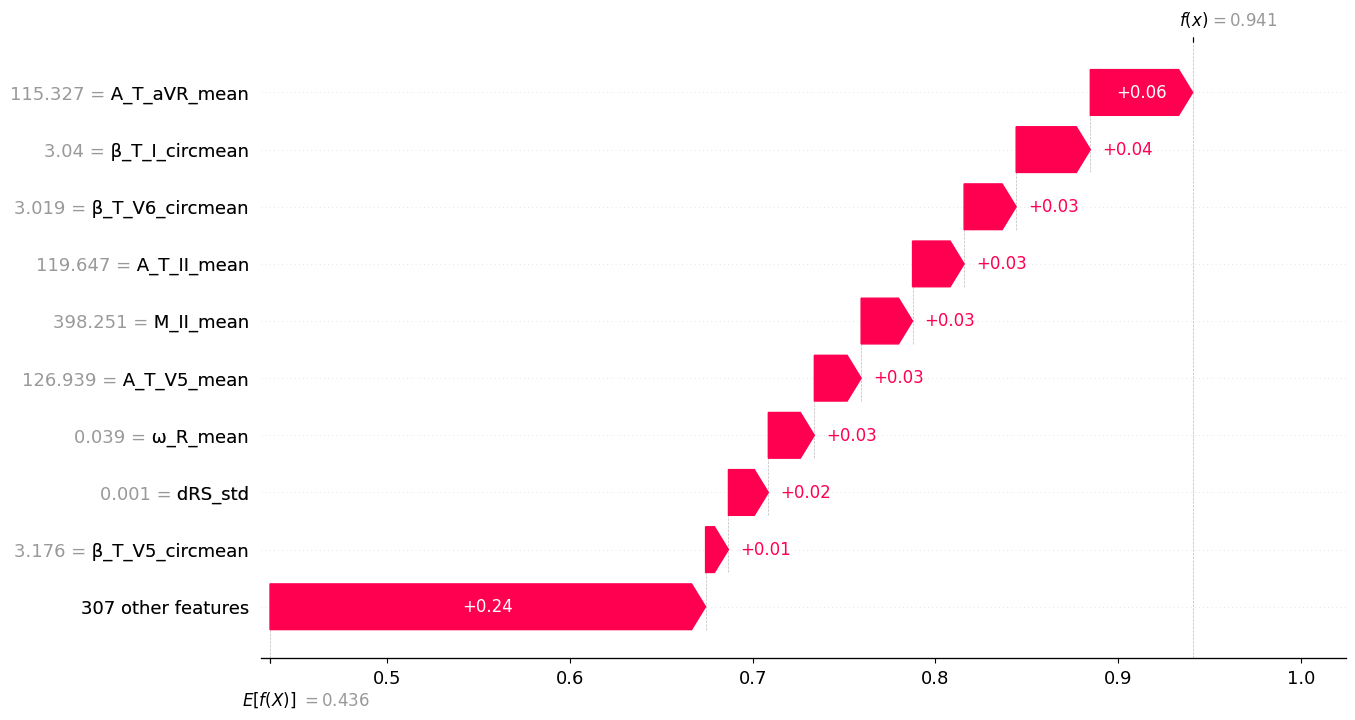

In [63]:
POSITIVE_CLASS = 1
TEST_INSTANCE_NUM = 17
X_ECG_ID = 121
NAME = "NORM"
explainer = explainers[NAME]
shap.initjs()
shap.waterfall_plot(
    shap.Explanation(
        values=shap_values_dict["NORM"][TEST_INSTANCE_NUM, :, POSITIVE_CLASS],
        base_values=explainer.expected_value[POSITIVE_CLASS],
        data=X_test.iloc[TEST_INSTANCE_NUM],
    ),
    show=False,
)
plt.gcf().set_size_inches(14, 8)  # Increase the width of the plot
plt.savefig(f"../img/local-shap-norm.png", dpi=300, bbox_inches="tight")
plt.show()

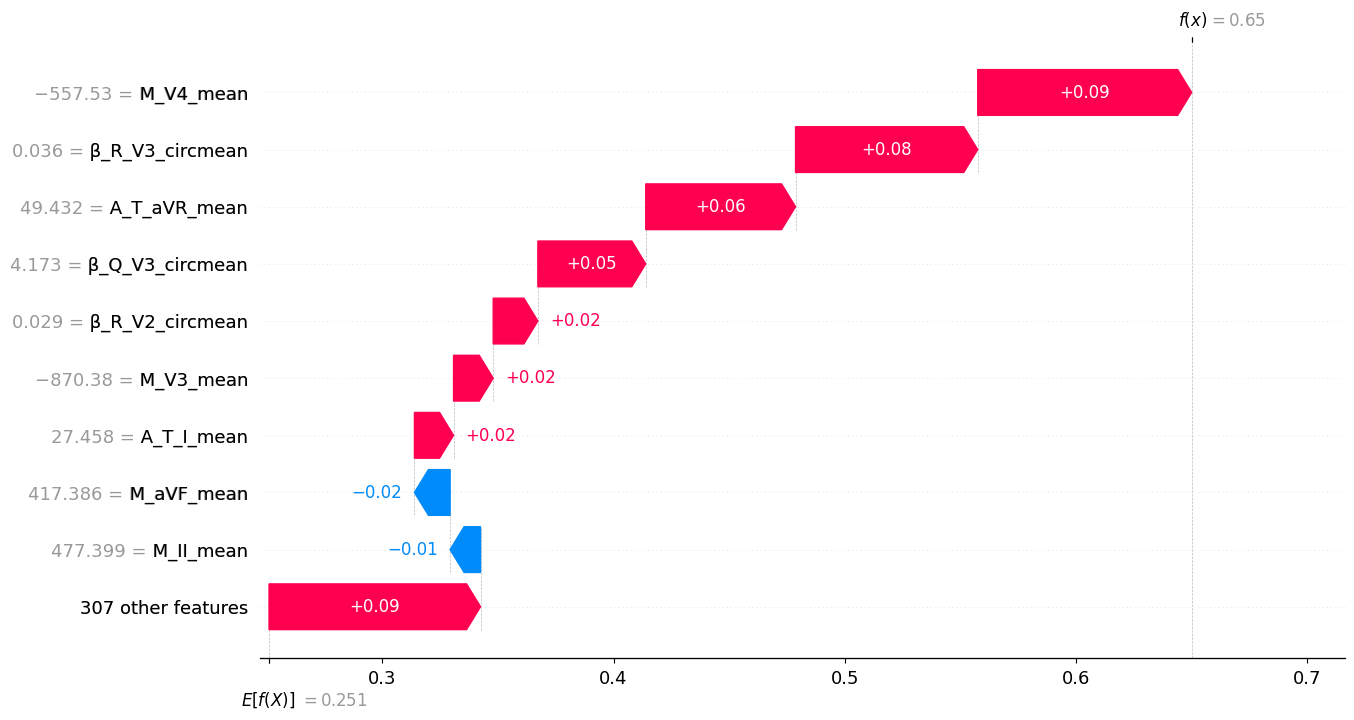

In [64]:
POSITIVE_CLASS = 1
TEST_INSTANCE_NUM = 70
X_ECG_ID = 526 #
NAME = "MI"
explainer = explainers[NAME]
shap.initjs()
shap.waterfall_plot(
    shap.Explanation(
        values=shap_values_dict["MI"][TEST_INSTANCE_NUM, :, POSITIVE_CLASS],
        base_values=explainer.expected_value[POSITIVE_CLASS],
        data=X_test.iloc[TEST_INSTANCE_NUM],
    ),
    show=False,
)
plt.gcf().set_size_inches(14, 8)  # Increase the width of the plot
plt.savefig(f"../img/local-shap-mi.png", dpi=300, bbox_inches="tight")
plt.show()

In [ ]:
# shap.initjs()
# shap_values_instance_0 = shap_values[-1,:,POSITIVE_CLASS]
# X_test_instance = X_test_encoded.iloc[0]
# shap.force_plot(explainer.expected_value[0], shap_values_instance_0, X_test_encoded.iloc[-1])

## Likelihood

In [65]:
X = pd.read_csv("../data/3dfmmecg_features.csv").sort_values(by="ecg_id")
X = X.loc[:, ~X.columns.isin([ID, GROUP, FOLD])]


QUALITIES = [15, 35, 50, 80, 100]
file = f"../data/y_all.csv"

lh_all = pd.read_csv(file).iloc[:, 1:]
y_all = lh_all.notna().astype(int)


model = None
for filename in os.listdir(MODELS_DIR):
    if filename.startswith(("all_3dfmmecg")):
        model_path = os.path.join(MODELS_DIR, filename)
        model = load(model_path)

y_scores = model.predict_proba(X)
y_scores.columns = y_all.columns
abs_diff = abs(y_all - y_scores)
auc_by_quality = dict()

for quality in QUALITIES:
    mask = lh_all == quality
    # Apply the mask to df2, setting other values to NaN
    abs_diff_masked = abs_diff.where(mask.values)

    abs_diff_masked = abs_diff_masked.values.flatten()
    abs_diff_masked = abs_diff_masked[~np.isnan(abs_diff_masked)]

    auc_by_quality[quality] = abs_diff_masked

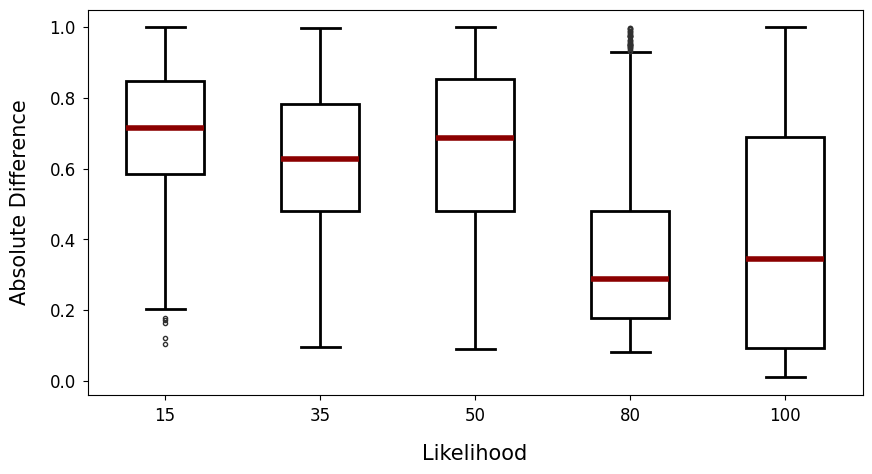

In [66]:
plot_data = []
for quality, values in auc_by_quality.items():
    for value in values:
        plot_data.append((quality, value))

plot_df = pd.DataFrame(plot_data, columns=['Quality', 'Absolute Difference'])

# Plot the multiple boxplot
plt.figure(figsize=(10, 5))

THICK = 2
# Customize the appearance of the boxplot
flierprops = dict(marker='o', markersize=3)
boxprops = dict(facecolor='none', edgecolor='black', linewidth=THICK)
whiskerprops = dict(color='black', linewidth=THICK)
capprops = dict(color='black', linewidth=THICK)
medianprops = dict(color='darkred', linewidth=THICK*2)

sns.boxplot(x='Quality', y='Absolute Difference', data=plot_df, 
            flierprops=flierprops, boxprops=boxprops, 
            whiskerprops=whiskerprops, capprops=capprops, 
            medianprops=medianprops, width=0.5)
plt.xlabel('Likelihood')
plt.ylabel('Absolute Difference')
plt.savefig("../img/likelihood.png", dpi=300, bbox_inches='tight')
plt.show()

In [45]:
# Perform Kruskal-Wallis H-test
groups = [plot_df[plot_df['Quality'] == quality]['Absolute Difference'].values for quality in plot_df['Quality'].unique()]
kruskal_result = kruskal(*groups)
print(kruskal_result)
# Perform Dunn's test for pairwise comparisons
dunn_result = posthoc_dunn(plot_df, val_col='Absolute Difference', group_col='Quality', p_adjust='bonferroni')
print(round(dunn_result, 3))

KruskalResult(statistic=np.float64(3603.7298257511607), pvalue=np.float64(0.0))
      15    35    50    80    100
15  1.000 0.000 0.000 0.000 0.000
35  0.000 1.000 0.888 0.000 0.000
50  0.000 0.888 1.000 0.000 0.000
80  0.000 0.000 0.000 1.000 1.000
100 0.000 0.000 0.000 1.000 1.000


## Reducing number of leads

In [46]:
MODELS_DIR = "../models"

models_prefixes = (
    "all_3dfmmecg",
    "diag_3dfmmecg",
    "subdiag_3dfmmecg",
    "superdiag_3dfmmecg",
    "form_3dfmmecg",
    "rhythm_3dfmmecg",
)

leads2remove = {
    8: ["III", "aVR", "aVL", "aVF"],
    3: ["I", "III", "aVR", "aVL", "aVF", "V1", "V3", "V4", "V5"],
    1: ["I", "III", "aVR", "aVL", "aVF", "V1", "V2", "V3", "V4", "V5", "V6"],
}

def remove_leads_features(df, leads):
    """Remove features that contain the specified leads in their names."""
    return df.drop(columns=[col for col in df.columns if any(f"_{lead}_" in col for lead in leads)])

In [ ]:
for filename in os.listdir(MODELS_DIR):
    problem = filename.split('_')[0]
    if not any(filename.startswith(prefix) for prefix in models_prefixes):
        continue
    # Load labels
    y = pd.read_csv(f"../data/y_{problem}.csv")
    lh = y.copy().fillna(0)
    # Because of versioning
    y.iloc[:, 1:] = y.iloc[:, 1:].map(lambda x: 1 if not pd.isna(x) else 0)
    y = y.reset_index(drop=True)

    y_train = (
        y.loc[y["ecg_id"].isin(train_idx), :]
        .drop(columns="ecg_id")
        .reset_index(drop=True)
    )
    lh_train = (
        lh.loc[lh["ecg_id"].isin(train_idx), :]
        .drop(columns="ecg_id")
        .reset_index(drop=True)
    )

    y_test = ( 
        y.loc[y["ecg_id"].isin(test_idx), :]
        .drop(columns="ecg_id")
        .reset_index(drop=True)
    )
    lh_test = (
        lh.loc[lh["ecg_id"].isin(test_idx), :]
        .drop(columns="ecg_id")
        .reset_index(drop=True)
    )
    
    model_path = os.path.join(MODELS_DIR, filename)
    model = PTBXLModel.load(model_path)
    for n, l2remove in leads2remove.items():
        X_train_reduced = remove_leads_features(X_train, l2remove)
        X_test_reduced = remove_leads_features(X_test, l2remove)
        name_prefix = f"{problem}_{n}L3dfmmecg"
        print(name_prefix, X_train_reduced.shape)
        model.fit(X_train_reduced, y_train)
        model.save(name_prefix, X_test_reduced, y_test, lh_test)

In [47]:
leads_12_coln = X_train.shape[1]
print(f"12-Lead: {leads_12_coln}")

12-Lead: 316


In [48]:
leads_8_coln = (remove_leads_features(X_train, leads2remove[8])).shape[1]
leads_8_red = 100*(1-leads_8_coln/leads_12_coln)
print(f"8-Lead: {leads_8_coln} ({leads_8_red:.2f}%)")

8-Lead: 228 (27.85%)


In [49]:
leads_3_coln = (remove_leads_features(X_train, leads2remove[3])).shape[1]
leads_3_red = 100*(1-leads_3_coln/leads_12_coln)
print(f"3-Lead: {leads_3_coln} ({leads_3_red:.2f}%)")

3-Lead: 108 (65.82%)


In [50]:
leads_1_coln = (remove_leads_features(X_train, leads2remove[1])).shape[1]
leads_1_red = 100*(1-leads_1_coln/leads_12_coln)
print(f"1-Lead: {leads_1_coln} ({leads_1_red:.2f}%)")

1-Lead: 60 (81.01%)


In [51]:
def extract_metrics_from_filename(filename):
    """Extract metrics and number of leads from the filename."""
    pattern = re.compile(r"_(\d*)L?3dfmmecg.*\.(\d+)\.(\d+)\.(\d+)\.(\d+)\.pkl$")
    match = pattern.search(filename)
    if match:
        n_leads = int(match.group(1)) if match.group(1) else 12
        macro_auc = int(match.group(2)) / 1000
        weighted_macro_auc = int(match.group(3)) / 1000
        instance_auc = int(match.group(4)) / 1000
        weighted_instance_auc = int(match.group(5)) / 1000
        return macro_auc, weighted_macro_auc, instance_auc, weighted_instance_auc
    return None


# Initialize a dictionary to store the data
data = {
    "problem": [],
    "n_leads": [],
    "w_macro_auc": [],
}

MODELS_DIR = "../models"
for problem in ["all", "diag", "subdiag", "superdiag", "form", "rhythm"]:
    for n_leads in [1, 3, 8, 12]:
        for filename in os.listdir(MODELS_DIR):
            lead_extra = "" if n_leads == 12 else f"{n_leads}L"
            if filename.startswith(f"{problem}_{lead_extra}3dfmmecg"):
                metrics = extract_metrics_from_filename(filename)
                if metrics:
                    (
                        macro_auc,
                        weighted_macro_auc,
                        instance_auc,
                        weighted_instance_auc,
                    ) = metrics
                    data["problem"].append(problem)
                    data["n_leads"].append(n_leads)
                    data["w_macro_auc"].append(weighted_macro_auc)

# Convert the data to a DataFrame
df = pd.DataFrame(data)

problem,all,diag,form,rhythm,subdiag,superdiag
n_leads,,,,,,
1,0.835,0.845,0.851,0.943,0.847,0.858
3,0.876,0.879,0.874,0.947,0.871,0.891
8,0.882,0.895,0.886,0.938,0.889,0.904
12,0.896,0.892,0.911,0.948,0.898,0.942


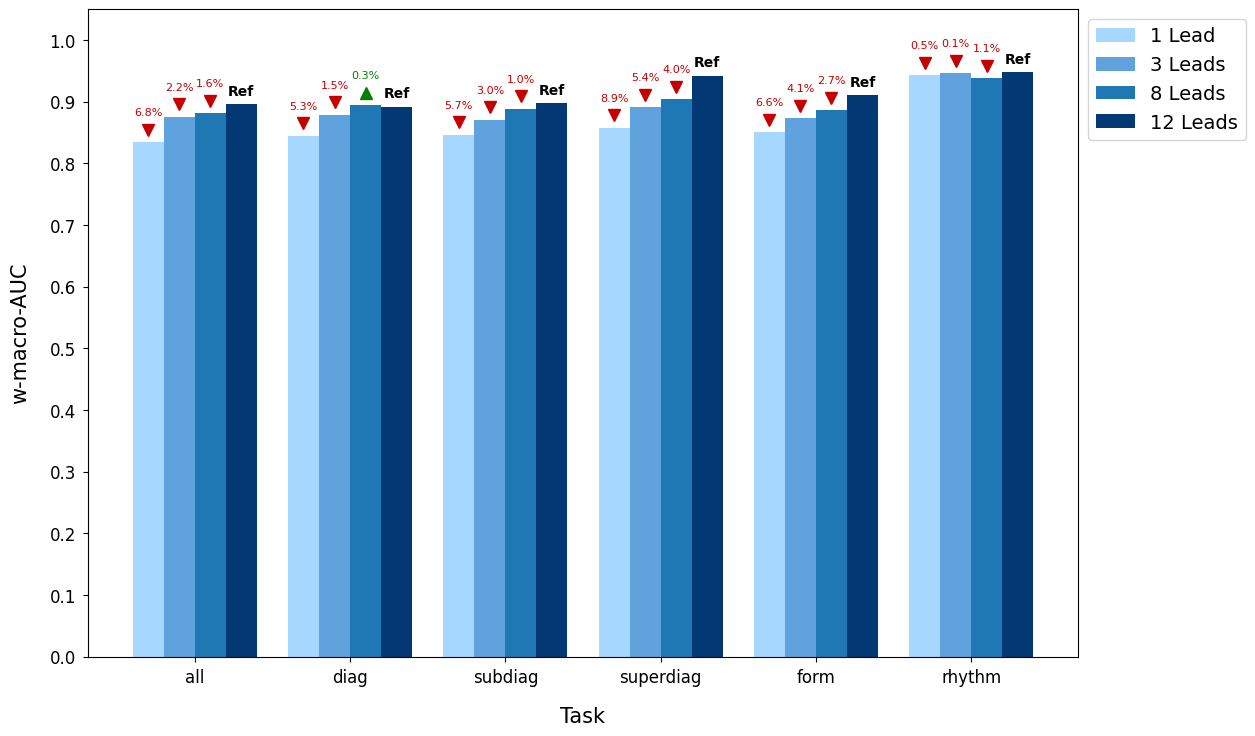

In [52]:
# Pivot the DataFrame to get the desired format
pivot_df = df.pivot(index="n_leads", columns="problem", values="w_macro_auc")

cmap = sns.diverging_palette(10, 150, as_cmap=True)
styled_pivot_table = pivot_df.style.format("{:.3f}").background_gradient(cmap=cmap)
display(styled_pivot_table)

# Prepare data for bar chart plotting
problems = df["problem"].unique()
n_leads = [1, 3, 8, 12]
bar_width = 0.5
index = np.arange(len(problems)) * (len(n_leads) * bar_width + 0.5)  # Increase the spacing factor here

# Create subplots for bar chart
fig, ax = plt.subplots(figsize=(15, 8))

# Define specific hex colors for the gradient
colors = list(reversed(["#023874", "#1f77b4", "#5fa2dd", "#a6d8ff"]))

# Plot bars for each number of leads
for i, leads in enumerate(n_leads):
    subset = df[df["n_leads"] == leads]
    means = [
        (
            subset[subset["problem"] == problem]["w_macro_auc"].values[0]
            if not subset[subset["problem"] == problem].empty
            else 0
        )
        for problem in problems
    ]
    label_suffix = "Lead" if leads == 1 else "Leads"
    bars = ax.bar(
        index + i * bar_width, means, bar_width, label=f"{leads} {label_suffix}", color=colors[i]
    )

    # Add triangles and labels between bars
    if leads != 12:  # Skip the reference (12 leads)
        for j, bar in enumerate(bars):
            prev_means = [
                (
                    df[(df["n_leads"] == 12) & (df["problem"] == problem)][
                        "w_macro_auc"
                    ].values[0]
                    if not df[(df["n_leads"] == 12) & (df["problem"] == problem)].empty
                    else 0
                )
                for problem in problems
            ]
            change = means[j] - prev_means[j]
            if change != 0:
                percentage_change = abs(change / prev_means[j]) * 100
                color = "green" if change > 0 else "#c40000"
                marker = "^" if change > 0 else "v"
                y_offset = 0.04  # Raise the annotation more on top of each bar
                ax.text(
                    bar.get_x() + bar.get_width() / 2,
                    bar.get_height() + y_offset,
                    f"{percentage_change:.1f}%",
                    ha="center",
                    va="bottom",
                    fontsize=8,
                    color=color,
                    #fontweight="bold",
                )
                ax.plot(
                    bar.get_x() + bar.get_width() / 2,
                    bar.get_height()
                    + y_offset
                    - 0.02,  # Add more space between the triangle and the label
                    color=color,
                    marker=marker,
                    markersize=8,
                    
                )
    else:  # Add "Ref" label on top of the 12-lead bar
        for j, bar in enumerate(bars):
            ax.text(
                bar.get_x() + bar.get_width() / 2,
                bar.get_height() + 0.01,  # Position the label slightly above the bar
                "Ref",
                ha="center",
                va="bottom",
                fontsize=10,
                color="black",
                fontweight="bold",
            )

# Customize the bar chart
ax.set_xlabel("Task")
ax.set_ylabel("w-macro-AUC")
ax.set_ylim(0, 1.05)
ax.set_yticks(np.arange(0, 1.1, 0.1))
ax.set_xticks(index + bar_width * 1.5)
ax.set_xticklabels(problems)
ax.legend(loc="upper left", bbox_to_anchor=(1, 1), ncol=1)

plt.tight_layout(pad=3.0)

# Add extra space on the left when saving the plot
plt.subplots_adjust(left=0.2)  # Adjust the left margin
plt.savefig("../img/reduced-leads.png", dpi=300, bbox_inches="tight")
plt.show()